In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun Jun 12 17:49:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   39C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2019 = db.rm_patent_cn_2019
    db_rm_us_2019 = db.rm_patent_us_2019
    db_rm_de_2019 = db.rm_patent_de_2019

    
except errors.ConnectionFailure as err:
    print(err)

# 2019

## Company數量

In [6]:
data_assignee = db_rm_de_2019.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_2019.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_2019.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
51,Qualcomm Inc,1229
53,Samsung Electronics Co Ltd,810
39,LG Electronics Inc,736
35,International Business Machines Corp,575
30,Huawei Technologies Co Ltd,570
69,Telefonaktiebolaget LM Ericsson AB,468
34,Intel Corp,318
18,Cisco Technology Inc,261
4,Apple Inc,227
43,Microsoft Technology Licensing LLC,218


In [12]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [13]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Qualcomm Inc,1229,7.113956
1,Samsung Electronics Co Ltd,810,6.697034
2,LG Electronics Inc,736,6.601230
3,International Business Machines Corp,575,6.354370
4,Huawei Technologies Co Ltd,570,6.345636
5,Telefonaktiebolaget LM Ericsson AB,468,6.148468
6,Intel Corp,318,5.762051
7,Cisco Technology Inc,261,5.564520
8,Apple Inc,227,5.424950
9,Microsoft Technology Licensing LLC,218,5.384495


In [14]:
com_ls = list(com_df.company)

## Data

In [15]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2019.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2019.csv")

In [16]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AR,AT,AU,BE,BR,CA,CH,CL,CN,...,PT,RS,RU,SE,SG,TN,TR,TW,US,ZA
29,AT&T Intellectual Property I LP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.0,0.0
216,Apple Inc,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,132.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,206.0,0.0
885,Cisco Technology Inc,0.0,0.0,5.0,0.0,0.0,9.0,0.0,0.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262.0,0.0
1939,Huawei Technologies Co Ltd,0.0,0.0,10.0,0.0,28.0,16.0,0.0,0.0,558.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,191.0,0.0
2110,Intel Corp,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,320.0,0.0


## Similarity計算

### Country

- 換成機率  

In [17]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [18]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AR,AT,AU,BE,BR,CA,CH,CL,CN,CO,...,PT,RS,RU,SE,SG,TN,TR,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000248,0.0,0.023065,0.0,0.026786,0.004712,0.0,0.000992,0.229167,0.001488,...,0.0,0.0,0.000992,0.0,0.043651,0.000248,0.0,0.071925,0.298115,0.000496
Samsung Electronics Co Ltd,0.000000,0.0,0.006011,0.0,0.000000,0.002254,0.0,0.000000,0.210744,0.000000,...,0.0,0.0,0.001878,0.0,0.006011,0.000000,0.0,0.011645,0.300526,0.000000
LG Electronics Inc,0.000703,0.0,0.004919,0.0,0.003514,0.001405,0.0,0.002108,0.085734,0.000000,...,0.0,0.0,0.003514,0.0,0.002811,0.000000,0.0,0.002108,0.517217,0.000000
International Business Machines Corp,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.073209,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.906542,0.001558
Huawei Technologies Co Ltd,0.000000,0.0,0.009191,0.0,0.025735,0.014706,0.0,0.000000,0.512868,0.000000,...,0.0,0.0,0.007353,0.0,0.000000,0.000000,0.0,0.000000,0.175551,0.000000


In [19]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [20]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [21]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [22]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [23]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

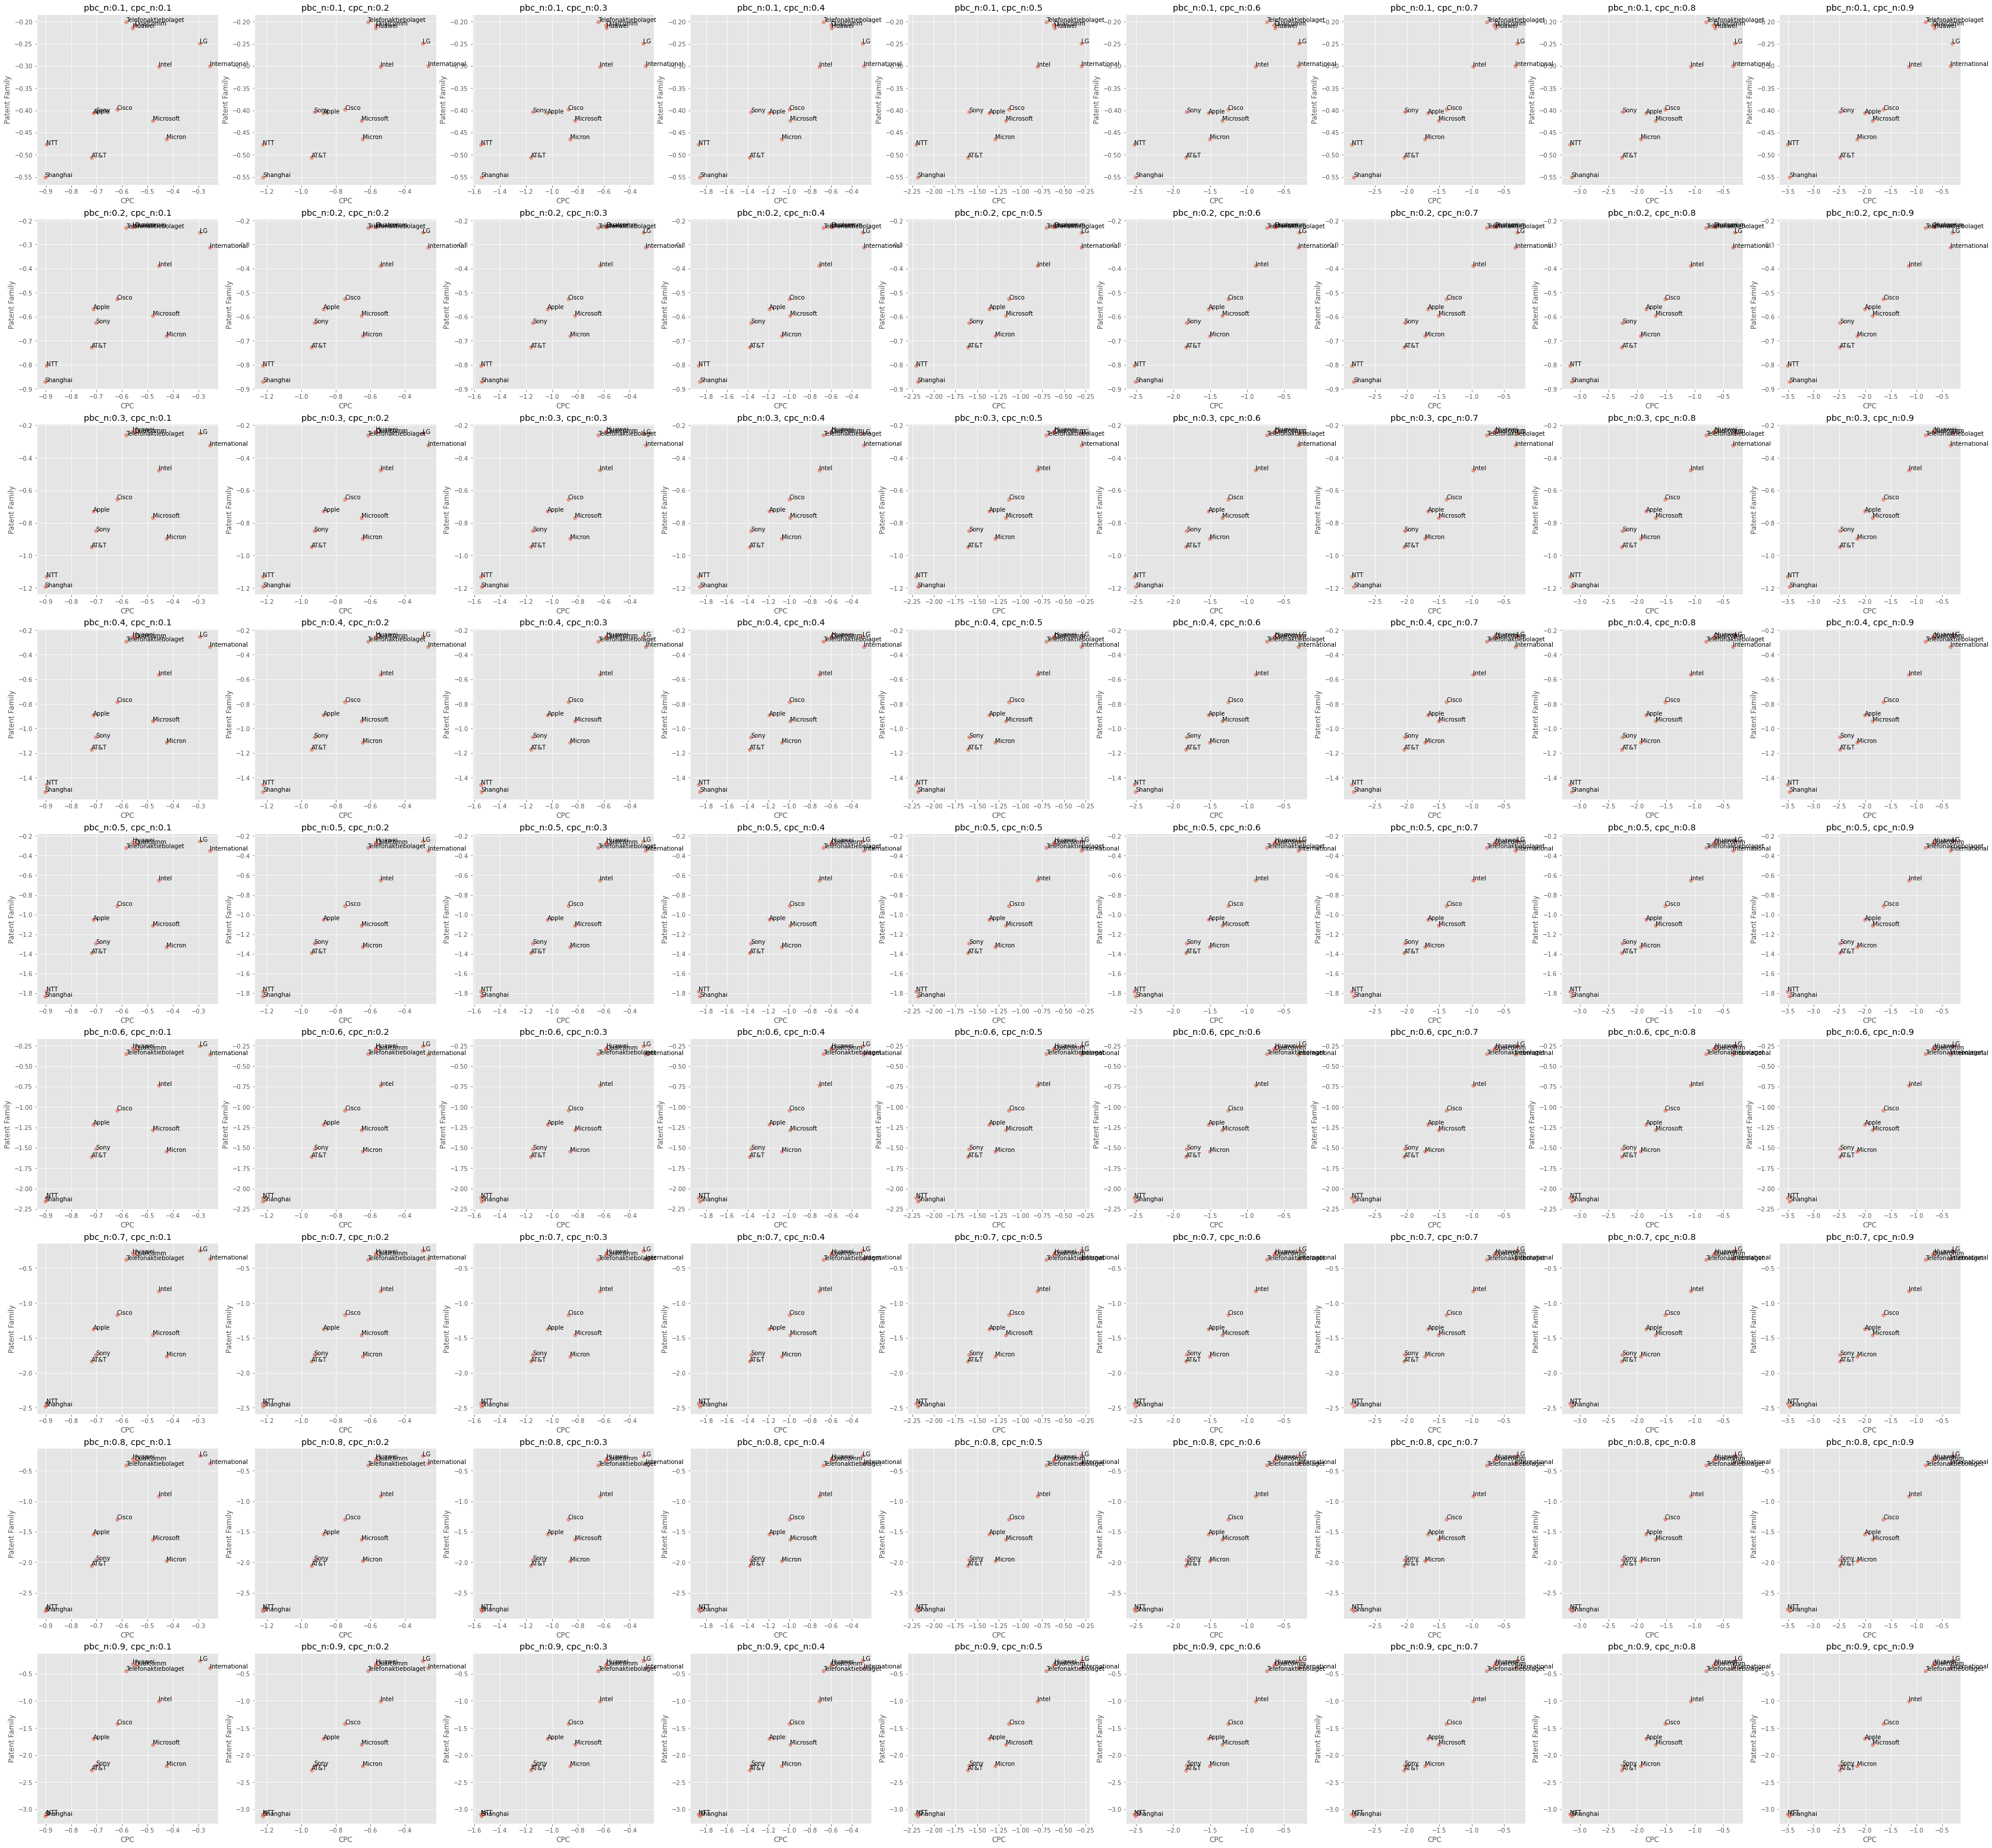

In [24]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2019_1.png'.format(pbc_n))

In [25]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.689254,0.347048
LG Electronics Inc,0.302280,0.256420
International Business Machines Corp,0.348016,0.393696
Huawei Technologies Co Ltd,0.656701,0.312783
Telefonaktiebolaget LM Ericsson AB,0.826002,0.441316
Intel Corp,1.154575,1.000540
Cisco Technology Inc,1.645719,1.424315
Apple Inc,2.006767,1.700533
Microsoft Technology Licensing LLC,1.858500,1.800998


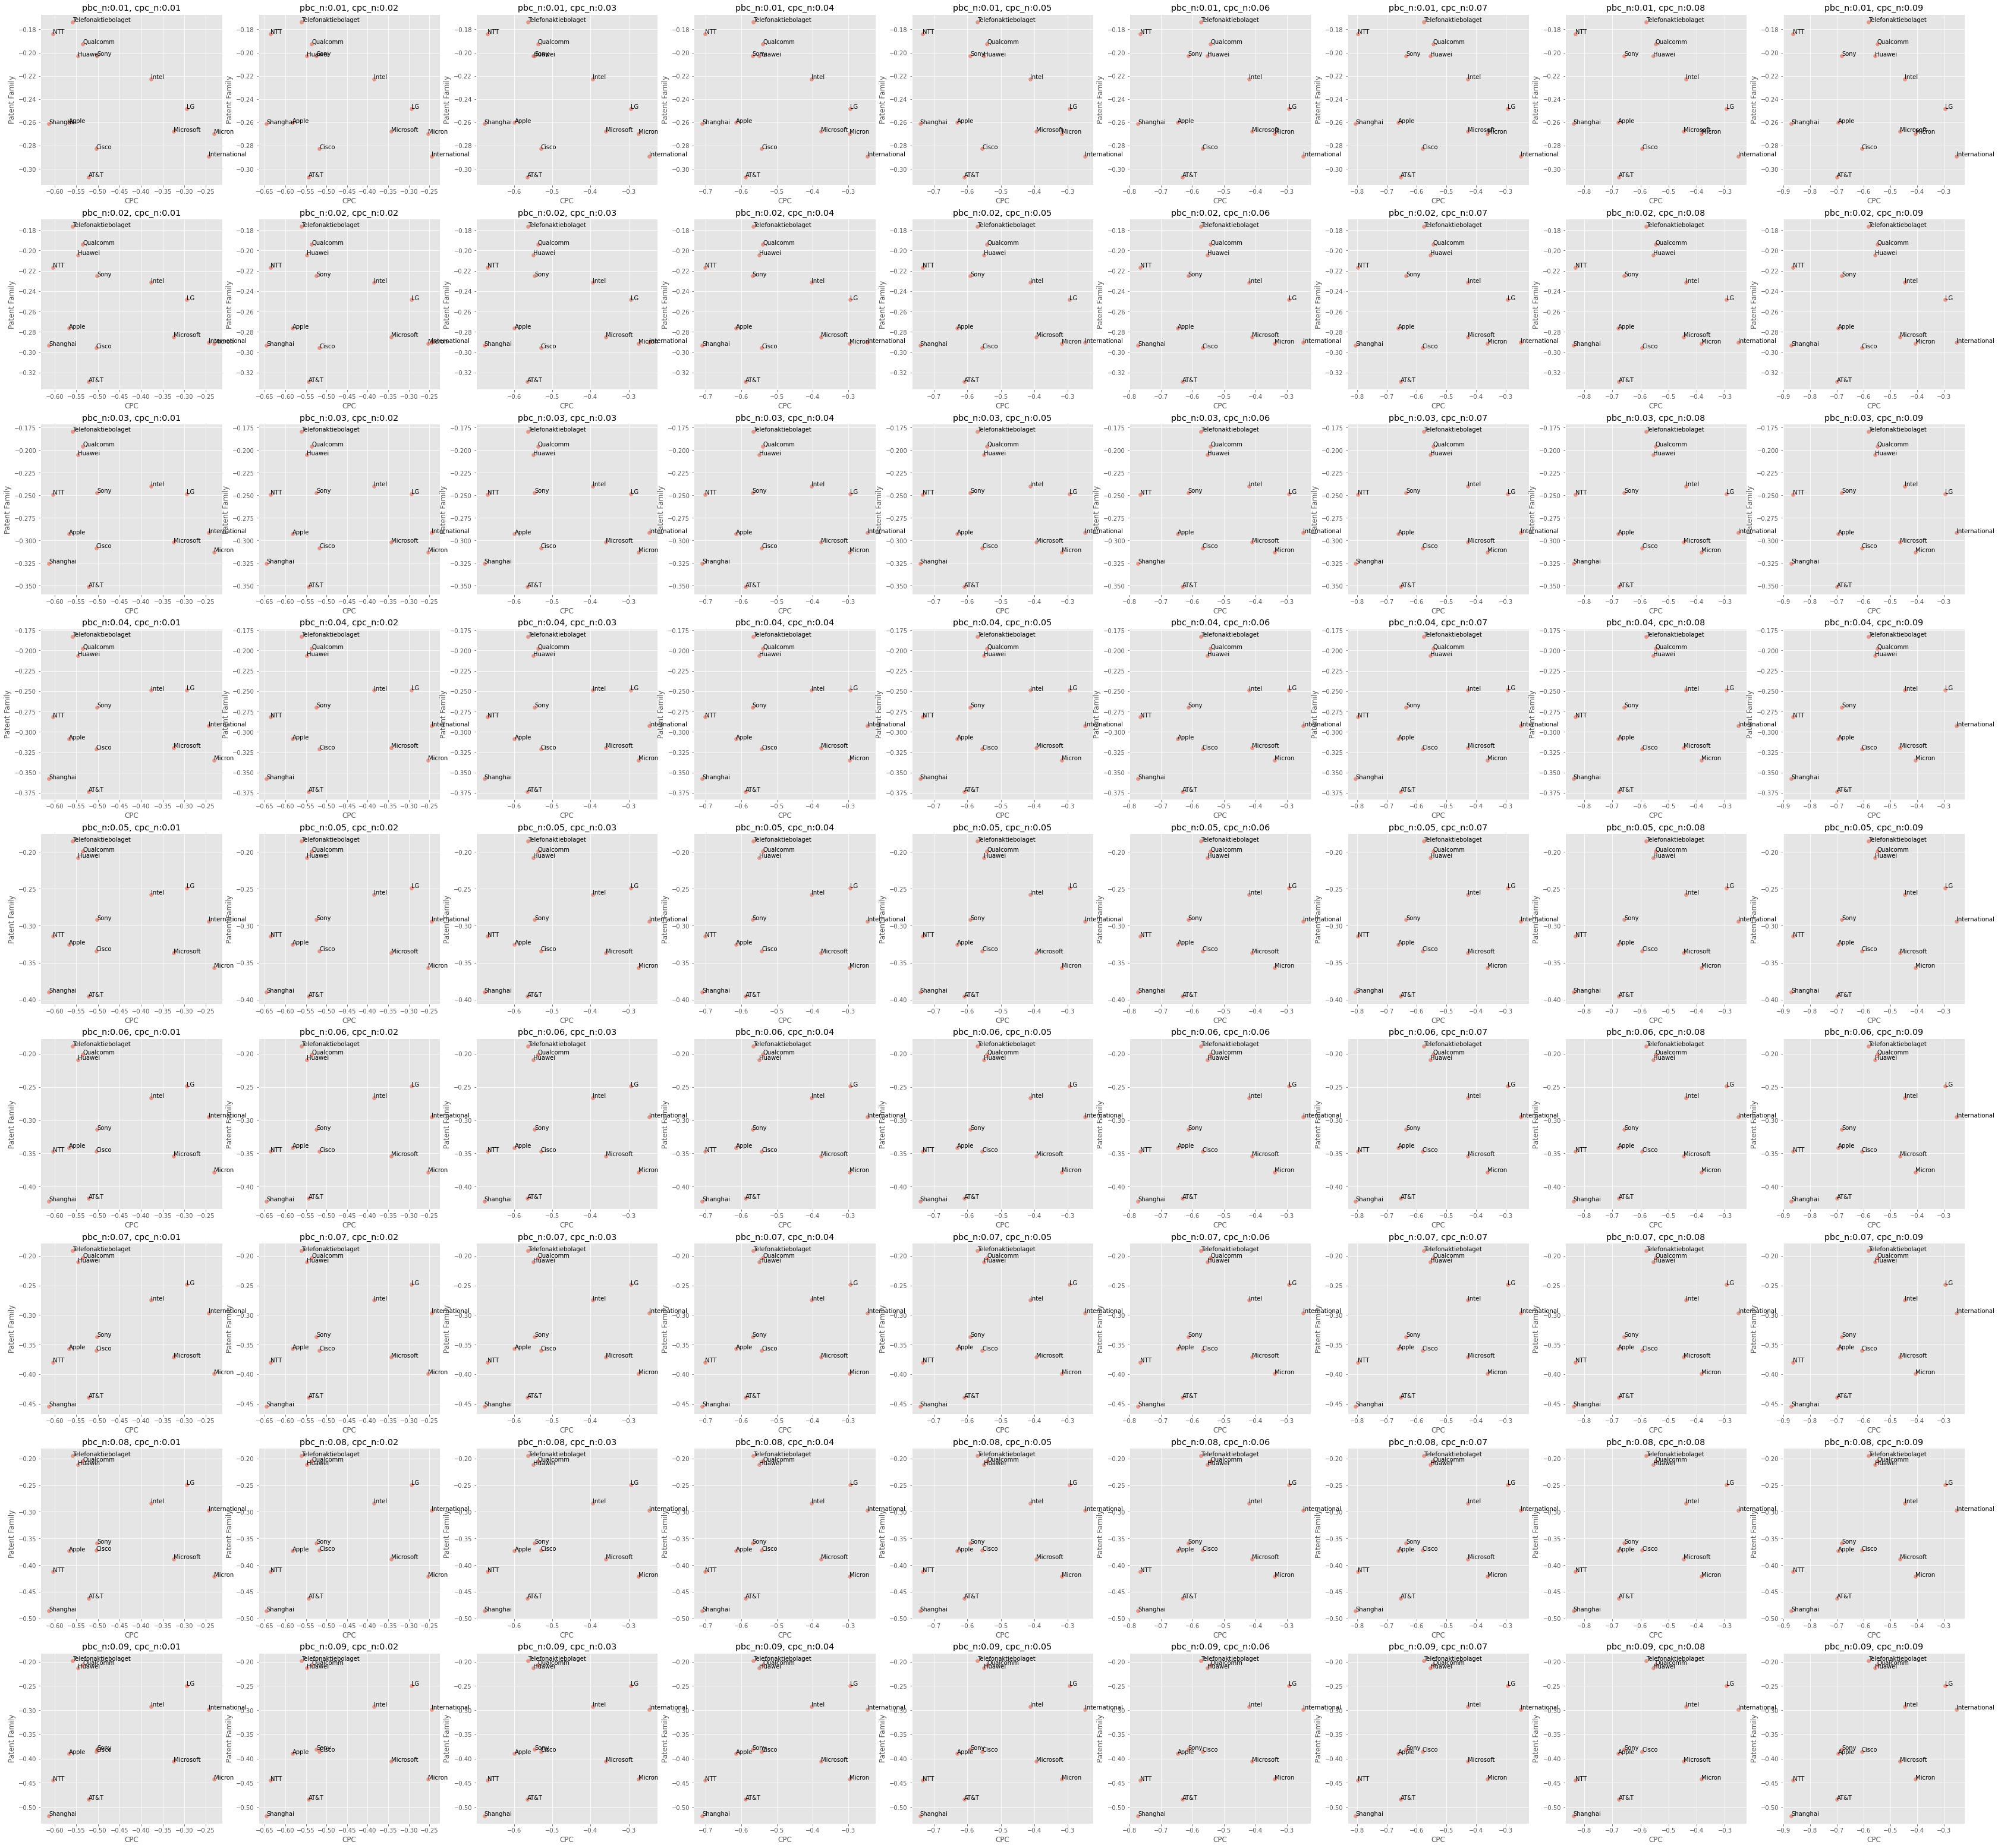

In [26]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2019_2.png'.format(pbc_n))

In [27]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.548457,0.206251
LG Electronics Inc,0.294845,0.248985
International Business Machines Corp,0.252907,0.298586
Huawei Technologies Co Ltd,0.556681,0.212764
Telefonaktiebolaget LM Ericsson AB,0.582253,0.197568
Intel Corp,0.446478,0.292444
Cisco Technology Inc,0.606823,0.385419
Apple Inc,0.696027,0.389792
Microsoft Technology Licensing LLC,0.463065,0.405563


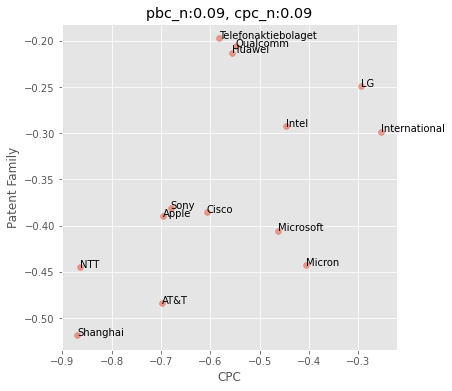

In [28]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')
c_df = scatter_plot(0.09,0.09)
c_df = c_df.drop("Samsung Electronics Co Ltd")

#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [29]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [30]:
competitor_ls

[1, 1, 1, 1, 2, 1, 4, 4, 3, 3, 4, 4, 4, 4]

In [31]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.548457,0.206251
LG Electronics Inc,0.294845,0.248985
International Business Machines Corp,0.252907,0.298586
Huawei Technologies Co Ltd,0.556681,0.212764
Telefonaktiebolaget LM Ericsson AB,0.582253,0.197568
Intel Corp,0.446478,0.292444
Cisco Technology Inc,0.606823,0.385419
Apple Inc,0.696027,0.389792
Microsoft Technology Licensing LLC,0.463065,0.405563
